# GCN with all connected nodes

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim

# Replace 'file.csv' with your file path
df = pd.read_csv('hgcal_electron_data_50000.csv')

# Display the first few rows of the dataframe
#print(df.head())

column_names = df.columns.tolist()

# Print the list of column names
#print(column_names)

columns_to_drop = ['nhits_total','xMean_layer0', 'xMean_layer1', 'xMean_layer2', 'xMean_layer3', 'xMean_layer4', 'xMean_layer5', 'xMean_layer6', 'xMean_layer7', 'xMean_layer8', 'xMean_layer9', 'xMean_layer10', 'xMean_layer11', 'xMean_layer12', 'xMean_layer13', 'xMean_layer14', 'xMean_layer15', 'xMean_layer16', 'xMean_layer17', 'xMean_layer18', 'xMean_layer19', 'xMean_layer20', 'xMean_layer21', 'xMean_layer22', 'xMean_layer23', 'xMean_layer24', 'xMean_layer25', 'xMean_layer26', 'xMean_layer27', 'xStd_layer0', 'xStd_layer1', 'xStd_layer2', 'xStd_layer3', 'xStd_layer4', 'xStd_layer5', 'xStd_layer6', 'xStd_layer7', 'xStd_layer8', 'xStd_layer9', 'xStd_layer10', 'xStd_layer11', 'xStd_layer12', 'xStd_layer13', 'xStd_layer14', 'xStd_layer15', 'xStd_layer16', 'xStd_layer17', 'xStd_layer18', 'xStd_layer19', 'xStd_layer20', 'xStd_layer21', 'xStd_layer22', 'xStd_layer23', 'xStd_layer24', 'xStd_layer25', 'xStd_layer26', 'xStd_layer27', 'yMean_layer0', 'yMean_layer1', 'yMean_layer2', 'yMean_layer3', 'yMean_layer4', 'yMean_layer5', 'yMean_layer6', 'yMean_layer7', 'yMean_layer8', 'yMean_layer9', 'yMean_layer10', 'yMean_layer11', 'yMean_layer12', 'yMean_layer13', 'yMean_layer14', 'yMean_layer15', 'yMean_layer16', 'yMean_layer17', 'yMean_layer18', 'yMean_layer19', 'yMean_layer20', 'yMean_layer21', 'yMean_layer22', 'yMean_layer23', 'yMean_layer24', 'yMean_layer25', 'yMean_layer26', 'yMean_layer27', 'yStd_layer0', 'yStd_layer1', 'yStd_layer2', 'yStd_layer3', 'yStd_layer4', 'yStd_layer5', 'yStd_layer6', 'yStd_layer7', 'yStd_layer8', 'yStd_layer9', 'yStd_layer10', 'yStd_layer11', 'yStd_layer12', 'yStd_layer13', 'yStd_layer14', 'yStd_layer15', 'yStd_layer16', 'yStd_layer17', 'yStd_layer18', 'yStd_layer19', 'yStd_layer20', 'yStd_layer21', 'yStd_layer22', 'yStd_layer23', 'yStd_layer24', 'yStd_layer25', 'yStd_layer26', 'yStd_layer27']
df = df.drop(columns_to_drop, axis=1)

#print("After dropping")

column_names = df.columns.tolist()

labels = df['target_energy'].values  # Assuming there's a 'label' column for graph labels

# Drop the label column to get the feature data
feature_data = df.drop(columns=['target_energy']).values

# Number of graphs
num_graphs = feature_data.shape[0]

# Number of nodes
num_nodes = 28

# Number of features per node
num_features_per_node = 4  # nhits, rMean, rStd, energySum, etc.

# Reshape the data to (num_graphs, num_nodes, num_features_per_node)
energySum_data = df[[f'energySum_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rMean_data = df[[f'rMean_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rStd_data = df[[f'rStd_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
nhits_data = df[[f'nhits_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))

# Concatenate features along the last dimension
feature_data = np.concatenate([energySum_data, rMean_data, rStd_data, nhits_data], axis=-1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(np.arange(num_graphs), test_size=0.2, random_state=42)

train_features = feature_data[train_indices]
train_labels = labels[train_indices]

test_features = feature_data[test_indices]
test_labels = labels[test_indices]

import torch_geometric.utils

# Create edge index for a fully connected graph with 28 nodes
edge_index = torch_geometric.utils.dense_to_sparse(torch.ones((num_nodes, num_nodes)))[0]

def create_data_list(features, labels):
    data_list = []
    for i in range(features.shape[0]):
        x = torch.tensor(features[i], dtype=torch.float)
        y = torch.tensor([labels[i]], dtype=torch.float)  # Ensure labels are float for regression
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

train_data_list = create_data_list(train_features, train_labels)
test_data_list = create_data_list(test_features, test_labels)

class GraphDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super(GraphDataset, self).__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

# Instantiate the datasets
train_dataset = GraphDataset(train_data_list)
test_dataset = GraphDataset(test_data_list)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)
        self.regressor = Linear(2, 1)  # Single output for regression

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.
        
        # Apply global pooling to aggregate node features
        h = global_mean_pool(h, batch)  # Aggregated features for each graph
        
        # Apply a final (linear) regressor.
        out = self.regressor(h).squeeze()  # Ensure output is [batch_size]

        return out

num_features = feature_data.shape[2]  # Number of features per node

model = GCN(num_features=num_features)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # Compute loss
        loss = F.mse_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.mse_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(100):
    train_loss = train()
    test_loss = test(test_loader)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# GCN with unidirectional edges with subsequent layers only

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim

# Replace 'file.csv' with your file path
df = pd.read_csv('hgcal_electron_data_50000.csv')

# Display the first few rows of the dataframe
#print(df.head())

column_names = df.columns.tolist()

# Print the list of column names
#print(column_names)

columns_to_drop = ['nhits_total','xMean_layer0', 'xMean_layer1', 'xMean_layer2', 'xMean_layer3', 'xMean_layer4', 'xMean_layer5', 'xMean_layer6', 'xMean_layer7', 'xMean_layer8', 'xMean_layer9', 'xMean_layer10', 'xMean_layer11', 'xMean_layer12', 'xMean_layer13', 'xMean_layer14', 'xMean_layer15', 'xMean_layer16', 'xMean_layer17', 'xMean_layer18', 'xMean_layer19', 'xMean_layer20', 'xMean_layer21', 'xMean_layer22', 'xMean_layer23', 'xMean_layer24', 'xMean_layer25', 'xMean_layer26', 'xMean_layer27', 'xStd_layer0', 'xStd_layer1', 'xStd_layer2', 'xStd_layer3', 'xStd_layer4', 'xStd_layer5', 'xStd_layer6', 'xStd_layer7', 'xStd_layer8', 'xStd_layer9', 'xStd_layer10', 'xStd_layer11', 'xStd_layer12', 'xStd_layer13', 'xStd_layer14', 'xStd_layer15', 'xStd_layer16', 'xStd_layer17', 'xStd_layer18', 'xStd_layer19', 'xStd_layer20', 'xStd_layer21', 'xStd_layer22', 'xStd_layer23', 'xStd_layer24', 'xStd_layer25', 'xStd_layer26', 'xStd_layer27', 'yMean_layer0', 'yMean_layer1', 'yMean_layer2', 'yMean_layer3', 'yMean_layer4', 'yMean_layer5', 'yMean_layer6', 'yMean_layer7', 'yMean_layer8', 'yMean_layer9', 'yMean_layer10', 'yMean_layer11', 'yMean_layer12', 'yMean_layer13', 'yMean_layer14', 'yMean_layer15', 'yMean_layer16', 'yMean_layer17', 'yMean_layer18', 'yMean_layer19', 'yMean_layer20', 'yMean_layer21', 'yMean_layer22', 'yMean_layer23', 'yMean_layer24', 'yMean_layer25', 'yMean_layer26', 'yMean_layer27', 'yStd_layer0', 'yStd_layer1', 'yStd_layer2', 'yStd_layer3', 'yStd_layer4', 'yStd_layer5', 'yStd_layer6', 'yStd_layer7', 'yStd_layer8', 'yStd_layer9', 'yStd_layer10', 'yStd_layer11', 'yStd_layer12', 'yStd_layer13', 'yStd_layer14', 'yStd_layer15', 'yStd_layer16', 'yStd_layer17', 'yStd_layer18', 'yStd_layer19', 'yStd_layer20', 'yStd_layer21', 'yStd_layer22', 'yStd_layer23', 'yStd_layer24', 'yStd_layer25', 'yStd_layer26', 'yStd_layer27']
df = df.drop(columns_to_drop, axis=1)

#print("After dropping")

column_names = df.columns.tolist()

labels = df['target_energy'].values  # Assuming there's a 'label' column for graph labels

# Drop the label column to get the feature data
feature_data = df.drop(columns=['target_energy']).values

# Number of graphs
num_graphs = feature_data.shape[0]

# Number of nodes
num_nodes = 28

# Number of features per node
num_features_per_node = 4  # nhits, rMean, rStd, energySum, etc.

# Reshape the data to (num_graphs, num_nodes, num_features_per_node)
energySum_data = df[[f'energySum_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rMean_data = df[[f'rMean_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rStd_data = df[[f'rStd_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
nhits_data = df[[f'nhits_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))

# Concatenate features along the last dimension
feature_data = np.concatenate([energySum_data, rMean_data, rStd_data, nhits_data], axis=-1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(np.arange(num_graphs), test_size=0.2, random_state=42)

train_features = feature_data[train_indices]
train_labels = labels[train_indices]

test_features = feature_data[test_indices]
test_labels = labels[test_indices]

# Create directed edge index for a chain graph where each node i is connected to node i+1
edge_index = torch.tensor([list(range(num_nodes - 1)), list(range(1, num_nodes))], dtype=torch.long)

# Verify the edge index
print(edge_index)

def create_data_list(features, labels, edge_index):
    data_list = []
    for i in range(features.shape[0]):
        x = torch.tensor(features[i], dtype=torch.float)
        y = torch.tensor([labels[i]], dtype=torch.float)  # Ensure labels are float for regression
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

train_data_list = create_data_list(train_features, train_labels, edge_index)
test_data_list = create_data_list(test_features, test_labels, edge_index)

class GraphDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super(GraphDataset, self).__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

# Instantiate the datasets
train_dataset = GraphDataset(train_data_list)
test_dataset = GraphDataset(test_data_list)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)
        self.regressor = Linear(2, 1)  # Single output for regression

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.
        
        # Apply global pooling to aggregate node features
        h = global_mean_pool(h, batch)  # Aggregated features for each graph
        
        # Apply a final (linear) regressor.
        out = self.regressor(h).squeeze()  # Ensure output is [batch_size]

        return out

num_features = feature_data.shape[2]  # Number of features per node

model = GCN(num_features=num_features)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # Compute loss
        loss = F.mse_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.mse_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(100):
    train_loss = train()
    test_loss = test(test_loader)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# GCN with nodes connected to all subsequesnt layers (Working)

In [69]:
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim

def log_cosh_loss(output, target):
    return torch.mean(torch.log(torch.cosh(output - target)))






# Replace 'file.csv' with your file path
df = pd.read_csv('hgcal_electron_data_50000.csv')

# Display the first few rows of the dataframe
#print(df.head())

column_names = df.columns.tolist()

# Print the list of column names
#print(column_names)

columns_to_drop = ['nhits_total','xMean_layer0', 'xMean_layer1', 'xMean_layer2', 'xMean_layer3', 'xMean_layer4', 'xMean_layer5', 'xMean_layer6', 'xMean_layer7', 'xMean_layer8', 'xMean_layer9', 'xMean_layer10', 'xMean_layer11', 'xMean_layer12', 'xMean_layer13', 'xMean_layer14', 'xMean_layer15', 'xMean_layer16', 'xMean_layer17', 'xMean_layer18', 'xMean_layer19', 'xMean_layer20', 'xMean_layer21', 'xMean_layer22', 'xMean_layer23', 'xMean_layer24', 'xMean_layer25', 'xMean_layer26', 'xMean_layer27', 'xStd_layer0', 'xStd_layer1', 'xStd_layer2', 'xStd_layer3', 'xStd_layer4', 'xStd_layer5', 'xStd_layer6', 'xStd_layer7', 'xStd_layer8', 'xStd_layer9', 'xStd_layer10', 'xStd_layer11', 'xStd_layer12', 'xStd_layer13', 'xStd_layer14', 'xStd_layer15', 'xStd_layer16', 'xStd_layer17', 'xStd_layer18', 'xStd_layer19', 'xStd_layer20', 'xStd_layer21', 'xStd_layer22', 'xStd_layer23', 'xStd_layer24', 'xStd_layer25', 'xStd_layer26', 'xStd_layer27', 'yMean_layer0', 'yMean_layer1', 'yMean_layer2', 'yMean_layer3', 'yMean_layer4', 'yMean_layer5', 'yMean_layer6', 'yMean_layer7', 'yMean_layer8', 'yMean_layer9', 'yMean_layer10', 'yMean_layer11', 'yMean_layer12', 'yMean_layer13', 'yMean_layer14', 'yMean_layer15', 'yMean_layer16', 'yMean_layer17', 'yMean_layer18', 'yMean_layer19', 'yMean_layer20', 'yMean_layer21', 'yMean_layer22', 'yMean_layer23', 'yMean_layer24', 'yMean_layer25', 'yMean_layer26', 'yMean_layer27', 'yStd_layer0', 'yStd_layer1', 'yStd_layer2', 'yStd_layer3', 'yStd_layer4', 'yStd_layer5', 'yStd_layer6', 'yStd_layer7', 'yStd_layer8', 'yStd_layer9', 'yStd_layer10', 'yStd_layer11', 'yStd_layer12', 'yStd_layer13', 'yStd_layer14', 'yStd_layer15', 'yStd_layer16', 'yStd_layer17', 'yStd_layer18', 'yStd_layer19', 'yStd_layer20', 'yStd_layer21', 'yStd_layer22', 'yStd_layer23', 'yStd_layer24', 'yStd_layer25', 'yStd_layer26', 'yStd_layer27']
df = df.drop(columns_to_drop, axis=1)

#print("After dropping")

column_names = df.columns.tolist()

labels = df['target_energy'].values  # Assuming there's a 'label' column for graph labels

# Drop the label column to get the feature data
feature_data = df.drop(columns=['target_energy']).values

# Number of graphs
num_graphs = feature_data.shape[0]

# Number of nodes
num_nodes = 28

# Number of features per node
num_features_per_node = 4  # nhits, rMean, rStd, energySum, etc.

# Reshape the data to (num_graphs, num_nodes, num_features_per_node)
energySum_data = df[[f'energySum_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rMean_data = df[[f'rMean_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rStd_data = df[[f'rStd_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
nhits_data = df[[f'nhits_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))

# Concatenate features along the last dimension
feature_data = np.concatenate([energySum_data, rMean_data, rStd_data, nhits_data], axis=-1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(np.arange(num_graphs), test_size=0.2, random_state=42)

train_features = feature_data[train_indices]
train_labels = labels[train_indices]

test_features = feature_data[test_indices]
test_labels = labels[test_indices]

# Create directed edge index for each node i connected to all nodes j where j > i
source_nodes = []
target_nodes = []

for i in range(num_nodes - 1):
    for j in range(i + 1, num_nodes):
        source_nodes.append(i)
        target_nodes.append(j)

edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

# Verify the edge index
print(edge_index)

def create_data_list(features, labels, edge_index):
    data_list = []
    for i in range(features.shape[0]):
        x = torch.tensor(features[i], dtype=torch.float)
        y = torch.tensor([labels[i]], dtype=torch.float)  # Ensure labels are float for regression
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

train_data_list = create_data_list(train_features, train_labels, edge_index)
test_data_list = create_data_list(test_features, test_labels, edge_index)

class GraphDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super(GraphDataset, self).__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

# Instantiate the datasets
train_dataset = GraphDataset(train_data_list)
test_dataset = GraphDataset(test_data_list)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)
        self.regressor = Linear(2, 1)  # Single output for regression

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.
        
        # Apply global pooling to aggregate node features
        h = global_mean_pool(h, batch)  # Aggregated features for each graph
        
        # Apply a final (linear) regressor.
        out = self.regressor(h).squeeze()  # Ensure output is [batch_size]

        return out

num_features = feature_data.shape[2]  # Number of features per node

model = GCN(num_features=num_features)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # Compute loss
        loss = F.l1_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            #loss = F.smooth_l1_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
            loss = F.l1_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(100):
    train_loss = train()
    test_loss = test(test_loader)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9,  9,

/home/codespace/.python/current/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 2)
  (regressor): Linear(in_features=2, out_features=1, bias=True)
)
Epoch 1, Train Loss: 171.5770, Test Loss: 169.6535
Epoch 2, Train Loss: 168.4470, Test Loss: 166.5234
Epoch 3, Train Loss: 165.3169, Test Loss: 163.3935
Epoch 4, Train Loss: 162.2020, Test Loss: 160.3122
Epoch 5, Train Loss: 159.1727, Test Loss: 157.3321
Epoch 6, Train Loss: 156.2374, Test Loss: 154.4447
Epoch 7, Train Loss: 153.3887, Test Loss: 151.6335
Epoch 8, Train Loss: 150.6155, Test Loss: 148.8930
Epoch 9, Train Loss: 147.9101, Test Loss: 146.2223
Epoch 10, Train Loss: 145.2726, Test Loss: 143.6191


KeyboardInterrupt: 

# GCN with Bidirectional edges with nearest neibhours

In [75]:
###################Bidirectional############
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim

def log_cosh_loss(output, target):
    return torch.mean(torch.log(torch.cosh(output - target)))

# Replace 'file.csv' with your file path
df = pd.read_csv('hgcal_electron_data_50000.csv')

# Display the first few rows of the dataframe
#print(df.head())

column_names = df.columns.tolist()

# Print the list of column names
#print(column_names)

columns_to_drop = ['nhits_total','xMean_layer0', 'xMean_layer1', 'xMean_layer2', 'xMean_layer3', 'xMean_layer4', 'xMean_layer5', 'xMean_layer6', 'xMean_layer7', 'xMean_layer8', 'xMean_layer9', 'xMean_layer10', 'xMean_layer11', 'xMean_layer12', 'xMean_layer13', 'xMean_layer14', 'xMean_layer15', 'xMean_layer16', 'xMean_layer17', 'xMean_layer18', 'xMean_layer19', 'xMean_layer20', 'xMean_layer21', 'xMean_layer22', 'xMean_layer23', 'xMean_layer24', 'xMean_layer25', 'xMean_layer26', 'xMean_layer27', 'xStd_layer0', 'xStd_layer1', 'xStd_layer2', 'xStd_layer3', 'xStd_layer4', 'xStd_layer5', 'xStd_layer6', 'xStd_layer7', 'xStd_layer8', 'xStd_layer9', 'xStd_layer10', 'xStd_layer11', 'xStd_layer12', 'xStd_layer13', 'xStd_layer14', 'xStd_layer15', 'xStd_layer16', 'xStd_layer17', 'xStd_layer18', 'xStd_layer19', 'xStd_layer20', 'xStd_layer21', 'xStd_layer22', 'xStd_layer23', 'xStd_layer24', 'xStd_layer25', 'xStd_layer26', 'xStd_layer27', 'yMean_layer0', 'yMean_layer1', 'yMean_layer2', 'yMean_layer3', 'yMean_layer4', 'yMean_layer5', 'yMean_layer6', 'yMean_layer7', 'yMean_layer8', 'yMean_layer9', 'yMean_layer10', 'yMean_layer11', 'yMean_layer12', 'yMean_layer13', 'yMean_layer14', 'yMean_layer15', 'yMean_layer16', 'yMean_layer17', 'yMean_layer18', 'yMean_layer19', 'yMean_layer20', 'yMean_layer21', 'yMean_layer22', 'yMean_layer23', 'yMean_layer24', 'yMean_layer25', 'yMean_layer26', 'yMean_layer27', 'yStd_layer0', 'yStd_layer1', 'yStd_layer2', 'yStd_layer3', 'yStd_layer4', 'yStd_layer5', 'yStd_layer6', 'yStd_layer7', 'yStd_layer8', 'yStd_layer9', 'yStd_layer10', 'yStd_layer11', 'yStd_layer12', 'yStd_layer13', 'yStd_layer14', 'yStd_layer15', 'yStd_layer16', 'yStd_layer17', 'yStd_layer18', 'yStd_layer19', 'yStd_layer20', 'yStd_layer21', 'yStd_layer22', 'yStd_layer23', 'yStd_layer24', 'yStd_layer25', 'yStd_layer26', 'yStd_layer27']
df = df.drop(columns_to_drop, axis=1)

#print("After dropping")

column_names = df.columns.tolist()

labels = df['target_energy'].values  # Assuming there's a 'label' column for graph labels

# Drop the label column to get the feature data
feature_data = df.drop(columns=['target_energy']).values

# Number of graphs
num_graphs = feature_data.shape[0]

# Number of nodes
num_nodes = 28

# Number of features per node
num_features_per_node = 4  # nhits, rMean, rStd, energySum, etc.

# Reshape the data to (num_graphs, num_nodes, num_features_per_node)
energySum_data = df[[f'energySum_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rMean_data = df[[f'rMean_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rStd_data = df[[f'rStd_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
nhits_data = df[[f'nhits_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))

# Concatenate features along the last dimension
feature_data = np.concatenate([energySum_data, rMean_data, rStd_data, nhits_data], axis=-1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(np.arange(num_graphs), test_size=0.2, random_state=42)

train_features = feature_data[train_indices]
train_labels = labels[train_indices]

test_features = feature_data[test_indices]
test_labels = labels[test_indices]

# Create bidirectional edge index for each node i connected to nodes i-1 and i+1
source_nodes = []
target_nodes = []

for i in range(num_nodes):
    if i > 0:  # Connect to the previous node
        source_nodes.append(i)
        target_nodes.append(i - 1)
        source_nodes.append(i - 1)
        target_nodes.append(i)
    if i < num_nodes - 1:  # Connect to the next node
        source_nodes.append(i)
        target_nodes.append(i + 1)
        source_nodes.append(i + 1)
        target_nodes.append(i)

edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

# Verify the edge index
print(edge_index)

def create_data_list(features, labels, edge_index):
    data_list = []
    for i in range(features.shape[0]):
        x = torch.tensor(features[i], dtype=torch.float)
        y = torch.tensor([labels[i]], dtype=torch.float)  # Ensure labels are float for regression
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

train_data_list = create_data_list(train_features, train_labels, edge_index)
test_data_list = create_data_list(test_features, test_labels, edge_index)

class GraphDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super(GraphDataset, self).__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

# Instantiate the datasets
train_dataset = GraphDataset(train_data_list)
test_dataset = GraphDataset(test_data_list)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 28)
        self.conv2 = GCNConv(28, 28)
        self.conv3 = GCNConv(28, 2)
        self.regressor = Linear(2, 1)  # Single output for regression

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.
        
        # Apply global pooling to aggregate node features
        h = global_mean_pool(h, batch)  # Aggregated features for each graph
        
        # Apply a final (linear) regressor.
        out = self.regressor(h).squeeze()  # Ensure output is [batch_size]

        return out

num_features = feature_data.shape[2]  # Number of features per node

model = GCN(num_features=num_features)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # Compute loss
        loss = F.l1_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.l1_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

for epoch in range(100):
    train_loss = train()
    test_loss = test(test_loader)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


tensor([[ 0,  1,  1,  0,  1,  2,  2,  1,  2,  3,  3,  2,  3,  4,  4,  3,  4,  5,
          5,  4,  5,  6,  6,  5,  6,  7,  7,  6,  7,  8,  8,  7,  8,  9,  9,  8,
          9, 10, 10,  9, 10, 11, 11, 10, 11, 12, 12, 11, 12, 13, 13, 12, 13, 14,
         14, 13, 14, 15, 15, 14, 15, 16, 16, 15, 16, 17, 17, 16, 17, 18, 18, 17,
         18, 19, 19, 18, 19, 20, 20, 19, 20, 21, 21, 20, 21, 22, 22, 21, 22, 23,
         23, 22, 23, 24, 24, 23, 24, 25, 25, 24, 25, 26, 26, 25, 26, 27, 27, 26],
        [ 1,  0,  0,  1,  2,  1,  1,  2,  3,  2,  2,  3,  4,  3,  3,  4,  5,  4,
          4,  5,  6,  5,  5,  6,  7,  6,  6,  7,  8,  7,  7,  8,  9,  8,  8,  9,
         10,  9,  9, 10, 11, 10, 10, 11, 12, 11, 11, 12, 13, 12, 12, 13, 14, 13,
         13, 14, 15, 14, 14, 15, 16, 15, 15, 16, 17, 16, 16, 17, 18, 17, 17, 18,
         19, 18, 18, 19, 20, 19, 19, 20, 21, 20, 20, 21, 22, 21, 21, 22, 23, 22,
         22, 23, 24, 23, 23, 24, 25, 24, 24, 25, 26, 25, 25, 26, 27, 26, 26, 27]])


/home/codespace/.python/current/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


GCN(
  (conv1): GCNConv(4, 28)
  (conv2): GCNConv(28, 28)
  (conv3): GCNConv(28, 2)
  (regressor): Linear(in_features=2, out_features=1, bias=True)
)
Epoch 1, Train Loss: 12.9604, Test Loss: 2.4162
Epoch 2, Train Loss: 2.6227, Test Loss: 2.2914
Epoch 3, Train Loss: 2.4962, Test Loss: 3.2106
Epoch 4, Train Loss: 2.6358, Test Loss: 2.9021
Epoch 5, Train Loss: 2.4288, Test Loss: 2.7591
Epoch 6, Train Loss: 2.4644, Test Loss: 2.2693
Epoch 7, Train Loss: 2.4587, Test Loss: 3.0662
Epoch 8, Train Loss: 2.4422, Test Loss: 2.5412
Epoch 9, Train Loss: 2.4670, Test Loss: 2.2671
Epoch 10, Train Loss: 2.4833, Test Loss: 2.2313
Epoch 11, Train Loss: 2.4367, Test Loss: 2.3117
Epoch 12, Train Loss: 2.4010, Test Loss: 2.4872
Epoch 13, Train Loss: 2.4389, Test Loss: 2.8672
Epoch 14, Train Loss: 2.4605, Test Loss: 2.4642
Epoch 15, Train Loss: 2.4143, Test Loss: 2.6864
Epoch 16, Train Loss: 2.3619, Test Loss: 2.3704
Epoch 17, Train Loss: 2.4101, Test Loss: 2.5519
Epoch 18, Train Loss: 2.4503, Test Loss: 2

In [76]:
print(feature_data.shape)

(50000, 28, 4)


In [77]:
model_save_path = 'trained_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to trained_model.pth


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the trained model
model_path = 'trained_model.pth'  # Replace with your actual model path
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

def evaluate_model(loader):
    model.eval()
    y_true = []
    y_pred = []
    
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            y_true.append(data.y.cpu().numpy())
            y_pred.append(out.cpu().numpy())
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mae, mse, r2

# Create DataLoaders for training and test datasets
train_loader = DataLoader(GraphDataset(train_data_list), batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(GraphDataset(test_data_list), batch_size=128, shuffle=False, num_workers=4)

# Evaluate the model on the training set
train_mae, train_mse, train_r2 = evaluate_model(train_loader)
print(f'Train MAE: {train_mae:.4f}, Train MSE: {train_mse:.4f}, Train R2: {train_r2:.4f}')

# Evaluate the model on the test set
test_mae, test_mse, test_r2 = evaluate_model(test_loader)
print(f'Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test R2: {test_r2:.4f}')



Train MAE: 2.2131, Train MSE: 8.6911, Train R2: 0.9991
Test MAE: 2.2207, Test MSE: 9.3202, Test R2: 0.9990


/home/codespace/.python/current/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


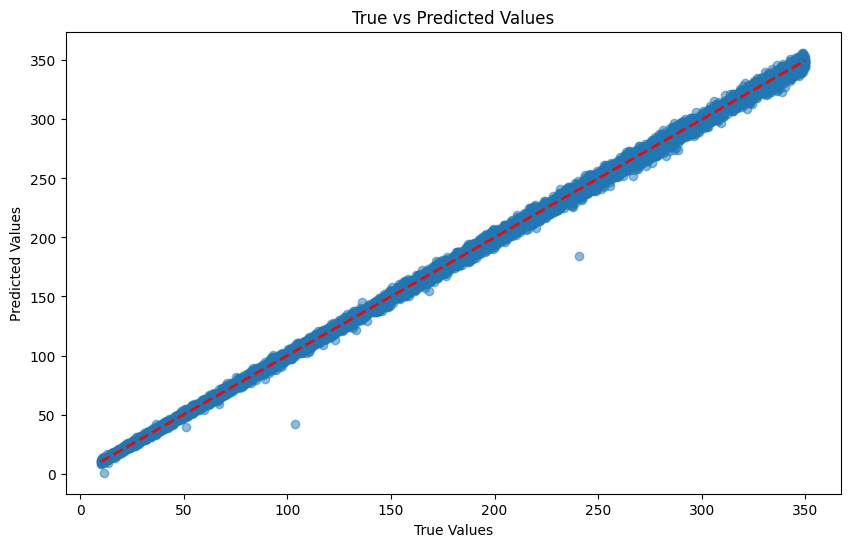

In [79]:
import torch
import numpy as np
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt

# Load the trained model
model_path = 'trained_model.pth'  # Replace with your actual model path
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Define a prediction function
def predict(model, loader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            predictions.append(out.cpu().numpy())
            true_values.append(data.y.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Get predictions and true values on the test dataset
test_predictions, test_true_values = predict(model, test_loader)

# Plot true values vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(test_true_values, test_predictions, alpha=0.5)
plt.plot([test_true_values.min(), test_true_values.max()], [test_true_values.min(), test_true_values.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()


In [85]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import DataLoader
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim

def log_cosh_loss(output, target):
    return torch.mean(torch.log(torch.cosh(output - target)))

# Replace 'file.csv' with your file path
df = pd.read_csv('../hgcal_electron_data.csv')
df = df[50000:100000]

# Display the first few rows of the dataframe
#print(df.head())

column_names = df.columns.tolist()

# Print the list of column names
#print(column_names)

#columns_to_drop = ['nhits_total','xMean_layer0', 'xMean_layer1', 'xMean_layer2', 'xMean_layer3', 'xMean_layer4', 'xMean_layer5', 'xMean_layer6', 'xMean_layer7', 'xMean_layer8', 'xMean_layer9', 'xMean_layer10', 'xMean_layer11', 'xMean_layer12', 'xMean_layer13', 'xMean_layer14', 'xMean_layer15', 'xMean_layer16', 'xMean_layer17', 'xMean_layer18', 'xMean_layer19', 'xMean_layer20', 'xMean_layer21', 'xMean_layer22', 'xMean_layer23', 'xMean_layer24', 'xMean_layer25', 'xMean_layer26', 'xMean_layer27', 'xStd_layer0', 'xStd_layer1', 'xStd_layer2', 'xStd_layer3', 'xStd_layer4', 'xStd_layer5', 'xStd_layer6', 'xStd_layer7', 'xStd_layer8', 'xStd_layer9', 'xStd_layer10', 'xStd_layer11', 'xStd_layer12', 'xStd_layer13', 'xStd_layer14', 'xStd_layer15', 'xStd_layer16', 'xStd_layer17', 'xStd_layer18', 'xStd_layer19', 'xStd_layer20', 'xStd_layer21', 'xStd_layer22', 'xStd_layer23', 'xStd_layer24', 'xStd_layer25', 'xStd_layer26', 'xStd_layer27', 'yMean_layer0', 'yMean_layer1', 'yMean_layer2', 'yMean_layer3', 'yMean_layer4', 'yMean_layer5', 'yMean_layer6', 'yMean_layer7', 'yMean_layer8', 'yMean_layer9', 'yMean_layer10', 'yMean_layer11', 'yMean_layer12', 'yMean_layer13', 'yMean_layer14', 'yMean_layer15', 'yMean_layer16', 'yMean_layer17', 'yMean_layer18', 'yMean_layer19', 'yMean_layer20', 'yMean_layer21', 'yMean_layer22', 'yMean_layer23', 'yMean_layer24', 'yMean_layer25', 'yMean_layer26', 'yMean_layer27', 'yStd_layer0', 'yStd_layer1', 'yStd_layer2', 'yStd_layer3', 'yStd_layer4', 'yStd_layer5', 'yStd_layer6', 'yStd_layer7', 'yStd_layer8', 'yStd_layer9', 'yStd_layer10', 'yStd_layer11', 'yStd_layer12', 'yStd_layer13', 'yStd_layer14', 'yStd_layer15', 'yStd_layer16', 'yStd_layer17', 'yStd_layer18', 'yStd_layer19', 'yStd_layer20', 'yStd_layer21', 'yStd_layer22', 'yStd_layer23', 'yStd_layer24', 'yStd_layer25', 'yStd_layer26', 'yStd_layer27']
#df = df.drop(columns_to_drop, axis=1)

#print("After dropping")

column_names = df.columns.tolist()

labels = df['target_energy'].values  # Assuming there's a 'label' column for graph labels

# Drop the label column to get the feature data
feature_data = df.drop(columns=['target_energy']).values

# Number of graphs
num_graphs = feature_data.shape[0]

# Number of nodes
num_nodes = 28

# Number of features per node
num_features_per_node = 4  # nhits, rMean, rStd, energySum, etc.

# Reshape the data to (num_graphs, num_nodes, num_features_per_node)
energySum_data = df[[f'energySum_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rMean_data = df[[f'rMean_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rStd_data = df[[f'rStd_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
nhits_data = df[[f'nhits_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))

# Concatenate features along the last dimension
feature_data = np.concatenate([energySum_data, rMean_data, rStd_data, nhits_data], axis=-1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(np.arange(num_graphs), test_size=0.2, random_state=42)

train_features = feature_data[train_indices]
train_labels = labels[train_indices]

test_features = feature_data[test_indices]
test_labels = labels[test_indices]



# Load the trained model
model_path = 'trained_model.pth'  # Replace with your actual model path
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Define a prediction function
def predict(model, loader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            predictions.append(out.cpu().numpy())
            true_values.append(data.y.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Create DataLoader for the labeled dataset
labeled_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Get predictions and true values
predicted_values, true_values = predict(model, labeled_loader)

# Save the results to a pandas DataFrame
results_df = pd.DataFrame({
    'True Values': true_values,
    'Predicted Values': predicted_values
})

# Write the DataFrame to a CSV file
results_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


/home/codespace/.python/current/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Predictions saved to predictions.csv


# 1000 Epochs and print every 100 epochs

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear
import torch.optim as optim

# Replace 'file.csv' with your file path
df = pd.read_csv('hgcal_electron_data_50000.csv')

# Display the first few rows of the dataframe
#print(df.head())

column_names = df.columns.tolist()

# Print the list of column names
#print(column_names)

columns_to_drop = ['nhits_total','xMean_layer0', 'xMean_layer1', 'xMean_layer2', 'xMean_layer3', 'xMean_layer4', 'xMean_layer5', 'xMean_layer6', 'xMean_layer7', 'xMean_layer8', 'xMean_layer9', 'xMean_layer10', 'xMean_layer11', 'xMean_layer12', 'xMean_layer13', 'xMean_layer14', 'xMean_layer15', 'xMean_layer16', 'xMean_layer17', 'xMean_layer18', 'xMean_layer19', 'xMean_layer20', 'xMean_layer21', 'xMean_layer22', 'xMean_layer23', 'xMean_layer24', 'xMean_layer25', 'xMean_layer26', 'xMean_layer27', 'xStd_layer0', 'xStd_layer1', 'xStd_layer2', 'xStd_layer3', 'xStd_layer4', 'xStd_layer5', 'xStd_layer6', 'xStd_layer7', 'xStd_layer8', 'xStd_layer9', 'xStd_layer10', 'xStd_layer11', 'xStd_layer12', 'xStd_layer13', 'xStd_layer14', 'xStd_layer15', 'xStd_layer16', 'xStd_layer17', 'xStd_layer18', 'xStd_layer19', 'xStd_layer20', 'xStd_layer21', 'xStd_layer22', 'xStd_layer23', 'xStd_layer24', 'xStd_layer25', 'xStd_layer26', 'xStd_layer27', 'yMean_layer0', 'yMean_layer1', 'yMean_layer2', 'yMean_layer3', 'yMean_layer4', 'yMean_layer5', 'yMean_layer6', 'yMean_layer7', 'yMean_layer8', 'yMean_layer9', 'yMean_layer10', 'yMean_layer11', 'yMean_layer12', 'yMean_layer13', 'yMean_layer14', 'yMean_layer15', 'yMean_layer16', 'yMean_layer17', 'yMean_layer18', 'yMean_layer19', 'yMean_layer20', 'yMean_layer21', 'yMean_layer22', 'yMean_layer23', 'yMean_layer24', 'yMean_layer25', 'yMean_layer26', 'yMean_layer27', 'yStd_layer0', 'yStd_layer1', 'yStd_layer2', 'yStd_layer3', 'yStd_layer4', 'yStd_layer5', 'yStd_layer6', 'yStd_layer7', 'yStd_layer8', 'yStd_layer9', 'yStd_layer10', 'yStd_layer11', 'yStd_layer12', 'yStd_layer13', 'yStd_layer14', 'yStd_layer15', 'yStd_layer16', 'yStd_layer17', 'yStd_layer18', 'yStd_layer19', 'yStd_layer20', 'yStd_layer21', 'yStd_layer22', 'yStd_layer23', 'yStd_layer24', 'yStd_layer25', 'yStd_layer26', 'yStd_layer27']
df = df.drop(columns_to_drop, axis=1)

#print("After dropping")

column_names = df.columns.tolist()

labels = df['target_energy'].values  # Assuming there's a 'label' column for graph labels

# Drop the label column to get the feature data
feature_data = df.drop(columns=['target_energy']).values


# Number of graphs
num_graphs = feature_data.shape[0]

# Number of nodes
num_nodes = 28

# Number of features per node
num_features_per_node = 4  # nhits, rMean, rStd, energySum, etc.

# Reshape the data to (num_graphs, num_nodes, num_features_per_node)
energySum_data = df[[f'energySum_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rMean_data = df[[f'rMean_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
rStd_data = df[[f'rStd_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))
nhits_data = df[[f'nhits_layer{i}' for i in range(num_nodes)]].values.reshape((num_graphs, num_nodes, 1))

# Concatenate features along the last dimension
feature_data = np.concatenate([energySum_data, rMean_data, rStd_data, nhits_data], axis=-1)

# Split the data into training and testing sets
train_indices, test_indices = train_test_split(np.arange(num_graphs), test_size=0.2, random_state=42)

train_features = feature_data[train_indices]
train_labels = labels[train_indices]

test_features = feature_data[test_indices]
test_labels = labels[test_indices]

# Create directed edge index for each node i connected to all nodes j where j > i
source_nodes = []
target_nodes = []

for i in range(num_nodes - 1):
    for j in range(i + 1, num_nodes):
        source_nodes.append(i)
        target_nodes.append(j)

edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

# Verify the edge index
print(edge_index)

def create_data_list(features, labels, edge_index):
    data_list = []
    for i in range(features.shape[0]):
        x = torch.tensor(features[i], dtype=torch.float)
        y = torch.tensor([labels[i]], dtype=torch.float)  # Ensure labels are float for regression
        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
    return data_list

train_data_list = create_data_list(train_features, train_labels, edge_index)
test_data_list = create_data_list(test_features, test_labels, edge_index)

class GraphDataset(InMemoryDataset):
    def __init__(self, data_list, transform=None):
        super(GraphDataset, self).__init__('.', transform)
        self.data, self.slices = self.collate(data_list)

# Instantiate the datasets
train_dataset = GraphDataset(train_data_list)
test_dataset = GraphDataset(test_data_list)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 2)
        self.regressor = Linear(2, 1)  # Single output for regression

    def forward(self, x, edge_index, batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()  # Final GNN embedding space.
        
        # Apply global pooling to aggregate node features
        h = global_mean_pool(h, batch)  # Aggregated features for each graph
        
        # Apply a final (linear) regressor.
        out = self.regressor(h).squeeze()  # Ensure output is [batch_size]

        return out

num_features = feature_data.shape[2]  # Number of features per node

model = GCN(num_features=num_features)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data.x, data.edge_index, data.batch)
        
        # Compute loss
        loss = F.mse_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.mse_loss(out, data.y.squeeze())  # Ensure target is [batch_size]
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Training for 1000 epochs and print loss every 100 epochs
for epoch in range(1000):
    train_loss = train()
    if (epoch + 1) % 100 == 0:
        test_loss = test(test_loader)
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
